In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from maraboupy import Marabou


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchsummary import summary

class BinaryClassification(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        self.linear_layer1 = nn.Linear(input_dimension, 32)
        self.linear_layer2 = nn.Linear(32, 32)
        self.linear_layer3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, input_dimension):
        x1 = self.relu(self.linear_layer1(input_dimension))
        x2 = self.relu(self.linear_layer2(x1))
        x3 = self.linear_layer3(x2)
        return x3

def configure_loss_function():
    return nn.BCEWithLogitsLoss()

def configure_optimizer(model):
    return torch.optim.Adam(model.parameters())

def full_gd(model, criterion, optimizer, train_loader, n_epochs):

    size_t = len(train_loader)
    for it in range(n_epochs): 
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            
            feature, label = data
            
            outputs = model(feature)
            optimizer.zero_grad()
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if (it + 1) % 50 == 0:
            print('[%d] loss: %.3f' % (it + 1, running_loss / n_epochs))



In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch


In [4]:
from maraboupy import Marabou
from maraboupy import MarabouCore

def getMarabou_CounterExamples(filename, inputName, outputName, size, multi_category, lb_dic, ub_dic, eps, options, step):
    network = Marabou.read_onnx(filename=filename, inputNames=[inputName], outputName = outputName)
    
    inputVars = network.inputVars[0][0]
    outputVars = network.outputVars[0]
    
    feature_num = inputVars.shape[0]
    eps1 = eps
    
    for h in range(feature_num):
        if h in multi_category.keys():
            num_category = multi_category[h]
            disjunction = []
            
            for i in range(num_category):         
                eq = MarabouCore.Equation(MarabouCore.Equation.EQ);
                eq.addAddend(1, inputVars[h]);
                eq.setScalar(i);
                disjunction.append([eq])

            network.addDisjunctionConstraint(disjunction)
            
            network.setLowerBound(inputVars[h], 0.0)
            network.setUpperBound(inputVars[h], multi_category[h])
        else:
            network.setLowerBound(inputVars[h], lb_dic[h])
            network.setUpperBound(inputVars[h], ub_dic[h])  


    ## output constraint
    network.setLowerBound(outputVars[0], -100.0)
    network.setUpperBound(outputVars[0], -0.2)
    
    res = []
    stat_temp = None
    choice = np.random.randint(feature_num, size=1)[0]
    for i in range(size):
        val,stat,lol = network.solve(options = options)
        if val == 'unsat':
            for h in range(feature_num):
                if h in multi_category.keys():
                    num_category = multi_category[h]
                    disjunction = []
                    for i in range(num_category):         
                        eq = MarabouCore.Equation(MarabouCore.Equation.EQ);
                        eq.addAddend(1, inputVars[h]);
                        eq.setScalar(i);
                        disjunction.append([eq])
                    network.addDisjunctionConstraint(disjunction)
                    
                    network.setLowerBound(inputVars[h], 0.0)
                    network.setUpperBound(inputVars[h], multi_category[h])
                else:
                    network.setLowerBound(inputVars[h], lb_dic[h])
                    network.setUpperBound(inputVars[h], ub_dic[h])
                    
            network.setLowerBound(outputVars[0], -100.0)
            network.setUpperBound(outputVars[0], -0.2+eps1)
            eps1 += eps
            
            if stat_temp != None:
                stat = stat_temp
                if stat[choice] - (ub_dic[choice]-lb_dic[choice]) / step > lb_dic[choice]:
                    network.setUpperBound(inputVars[choice], stat[choice]-(ub_dic[choice]-lb_dic[choice]) / step)
                else:
                    network.setUpperBound(inputVars[choice], stat[choice]+(ub_dic[choice]-lb_dic[choice]) / step)
                stat_temp = None
            
            val,stat,lol = network.solve(options = options)
        
        if val == 'unsat':
            return np.array(res)
        
        stat_temp = stat
        
        counter_example = []
        for j in range(feature_num):
            counter_example.append(stat[j])
        res.append(np.array(counter_example))    
        
        if not choice in multi_category.keys():
            if stat[choice] + (ub_dic[choice]-lb_dic[choice]) / step < ub_dic[choice]:
                network.setLowerBound(inputVars[choice], stat[choice]+(ub_dic[choice]-lb_dic[choice]) / step)
            else:
                network.setLowerBound(inputVars[choice], stat[choice]-(ub_dic[choice]-lb_dic[choice]) / step)
        choice = np.random.randint(feature_num, size=1)[0]
    
    return np.array(res)

In [5]:
import torch.onnx
from sklearn.preprocessing import MinMaxScaler

def Correct_Accuracy(X, y_pred, y_true, multi_category, lb_dic, ub_dic, y_constraint):
    _, input_dimension = X.shape
    total, score = len(X), 0 
    count = 0
    for index, x in enumerate(X):
        flag = True
        for i, val in enumerate(x):
            if i in multi_category.keys():
                if val in range(multi_category[i]):
                    continue
                else:
                    flag = False
                    break     
            else:
                if x[i] >= lb_dic[i] and x[i] <= ub_dic[i]:
                     continue
                else:
                    flag = False
                    break      
        
        if flag == True:
            if y_pred[index][0] == y_constraint:
                score += 1
            else:
                count += 1
        else:
            if y_pred[index][0] == y_true[index]:
                score += 1
    print(count)
    return score / total, count

def full_model_training(X_train, y_train, X_test, y_test, multi_category, lb_dic, ub_dic, lb_dic_d, ub_dic_d,y_constraint, batch):
    _, input_dimension = X_train.shape
    model = BinaryClassification(input_dimension)
    BATCH_SIZE = batch
    
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    X_train_tensor = torch.from_numpy(X_train_sc.astype(np.float32))
    X_test_tensor = torch.from_numpy(X_test_sc.astype(np.float32))
    y_train_tensor = torch.from_numpy(y_train.astype(np.float32)).reshape(-1, 1)
    y_test_tensor = torch.from_numpy(y_test.astype(np.float32)).reshape(-1, 1)
    dealDataSet = TensorDataset(X_train_tensor,y_train_tensor)
    train_Loader = DataLoader(dataset=dealDataSet, batch_size=BATCH_SIZE,shuffle=True)
    dealDataSet = TensorDataset(X_test_tensor,y_test_tensor)
    test_Loader = DataLoader(dataset=dealDataSet, batch_size=BATCH_SIZE,shuffle=True)
    
    del X_train_tensor
    del y_train_tensor
    
    criterion = configure_loss_function()
    optimizer = configure_optimizer(model)
    full_gd(model, criterion, optimizer, train_Loader, n_epochs=100)
    
    with torch.no_grad():

        p_test = model(X_test_tensor)
        p_test = (p_test.numpy() > 0)
  
        test_acc = np.mean(y_test_tensor.numpy() == p_test)
    
        correct_accuracy_test, count = Correct_Accuracy(X_test, p_test, y_test, multi_category, lb_dic, ub_dic, y_constraint)
        
    x_example = torch.randn(1, input_dimension, requires_grad=False)
    print("stuck")
    torch.onnx.export(model,
                 x_example,
                 "naive_bc.onnx",
                 export_params=True,
                 opset_version=11,
                 do_constant_folding=True,
                 input_names=['Placeholder'],
                 output_names=['output'])
    
    return correct_accuracy_test, test_acc, model, count

In [6]:
import gc
from sklearn.preprocessing import MinMaxScaler

def pre_correcting(X, y, multi_category, lb_dic, ub_dic, y_constraint):
    
    count = 0
    for index, x in enumerate(X):
        flag = True
        for i, val in enumerate(x):
            if i in multi_category.keys():
                if val in range(multi_category[i]):
                    continue
                else:
                    flag = False
                    break     
            else:
                if val >= lb_dic[i] and val <= ub_dic[i]:
                     continue
                else:
                    flag = False
                    break      
        
        if flag == True:
            if y[index] != y_constraint:
                y[index] = y_constraint
                count += 1
    print("Corrected:", count)
    

def CeGL_training(X_train, y_train, X_test, y_test, 
                  multi_category, lb_dic, ub_dic, lb_dic_d, ub_dic_d, y_constraint,
                  prop_ce, max_iter, eps, early_stop, batch, step):
    
    n_iter = 0
    train_size, input_dimension = X_train.shape
    CE_size = np.ceil(train_size * prop_ce)
    print(CE_size)
    Correct_Acc_prev, Model_prev = 0, None
    correct_acc_arr = []
    count_arr = []
    
    while n_iter < max_iter:
        
        print(f'{n_iter} th iteration')
        
        res_ca, res_acc, cur_model, count = full_model_training(X_train, y_train, X_test, y_test,
                       multi_category=multi_category, lb_dic = lb_dic, ub_dic = ub_dic, 
                                        lb_dic_d = lb_dic_d, ub_dic_d = ub_dic_d, y_constraint=y_constraint, batch=batch)
        gc.collect()
        
        if n_iter == 0:
            ## pre-correcting
            pre_correcting(X_train, y_train, multi_category, lb_dic, ub_dic, y_constraint)
            
        print("hi")
        
        if n_iter != 0 and early_stop == True:
            if res_ca - Correct_Acc_prev < abs(eps):
                res_ca = Correct_Acc_prev
                cur_model = Model_prev
                break
        print(res_ca, res_acc)
        Correct_Acc_prev = res_ca
        Model_prev = cur_model
        correct_acc_arr.append(res_ca)
        count_arr.append(count)
 
        inputName = 'Placeholder'
        outputName = 'output'
        filename = 'naive_bc.onnx'

        options = Marabou.createOptions(verbosity = 0)
        ce = getMarabou_CounterExamples(filename = filename, inputName=inputName, outputName = outputName, size = int(CE_size),
                                    multi_category=multi_category, lb_dic = lb_dic_d, ub_dic = ub_dic_d, eps = eps, 
                                        options = options, step = step)
        gc.collect()
        
        ce_n = len(ce)
        if len(ce) == 0:
            n_iter += 1
            break
        ce_label = []
        for i in range(ce_n):
            ce_label.append(y_constraint)
    
        X_train = np.vstack([X_train,ce])
        y_train = np.append(y_train,ce_label)
            
        n_iter += 1
            
    print(res_ca, res_acc)        
    best_model = cur_model
    return best_model, correct_acc_arr, count_arr

In [7]:

df = pd.read_csv("./citrus.csv")

df.name[df.name == 'orange'] = 0
df.name[df.name == 'grapefruit'] = 1

X = df.drop(['name'], axis = 1)
y = df['name']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X.head()


,diameter,weight,red,green,blue
0,2.96,86.76,172,85,2
1,3.91,88.05,166,78,3
2,4.42,95.17,156,81,2
3,4.47,95.60,163,81,4
4,4.48,95.76,161,72,9


In [8]:
print(df.max(axis=0))
print(df.min(axis=0))

name             1
diameter     16.45
weight      261.51
red            192
green          116
blue            56
dtype: object
name            0
diameter     2.96
weight      86.76
red           115
green          31
blue            2
dtype: object


In [9]:
sc = MinMaxScaler()
sc.fit(X_train)
print(sc.transform([[0,95,0,75,10]]))

[[-0.21942179  0.04715308 -1.49350649  0.4875      0.14814815]]


In [10]:
torch.manual_seed(0)

eps = 1e-5
multi_category = { }
lb_dic = { 
    0:2.0,
    1:100.0,
    2:0.0,
    3:75.0,
    4:10.0
}
ub_dic = { 
    0:20.0,
    1:300.0,
    2:255.0,
    3:255.0,
    4:255.0
}

lb_dic_d = { 
    0:0.0,
    1:0.02904,
    2:0.0,
    3:0.51765,
    4:1.7778e-1
}
ub_dic_d = { 
    0:1.0,
    1:1.0,
    2:1.0,
    3:1.0,
    4:1.0
}

y_constraint = 1
prop_ce = 0.02
max_iter = 20
step = 500
early_stop = False
batch = 16

model, Correct_Acc1, count1 = CeGL_training(np.copy(X_train), np.copy(y_train), np.copy(X_test), np.copy(y_test),
                  multi_category = multi_category, lb_dic = lb_dic, ub_dic = ub_dic, 
                                            lb_dic_d = lb_dic_d, ub_dic_d = ub_dic_d, y_constraint=y_constraint, 
                   prop_ce = prop_ce, max_iter = max_iter, eps = eps, early_stop=early_stop, batch = batch, step = step)

150.0
0 th iteration
[50] loss: 0.838
[100] loss: 0.815
289
stuck
Corrected: 862
hi
0.8344 0.9316
sat
input 0 = 0.4946425352660528
input 1 = 0.02904
input 2 = 0.6080214476527402
input 3 = 0.51765
input 4 = 0.2540023189348811
output 0 = -0.2
sat
input 0 = 0.4950268981884828
input 1 = 0.03098192
input 2 = 0.609492974775715
input 3 = 0.51765
input 4 = 0.25406510147810485
output 0 = -0.2
sat
input 0 = 0.49561508749340694
input 1 = 0.03098192
input 2 = 0.611492974775715
input 3 = 0.51765
input 4 = 0.2538004295587916
output 0 = -0.2
sat
input 0 = 0.5969040718860574
input 1 = 0.03098192
input 2 = 0.9888613840353754
input 3 = 0.51765
input 4 = 0.25544486955879164
output 0 = -0.2
sat
input 0 = 0.5989040718860574
input 1 = 0.045008605112443034
input 2 = 1.0
input 3 = 0.5389952352048824
input 4 = 0.25544486955879164
output 0 = -0.4261869918787574
sat
input 0 = 0.6009040718860574
input 1 = 0.05019860024224661
input 2 = 1.0
input 3 = 0.5442492196825911
input 4 = 0.25544486955879164
output 0 = -0.42

sat
input 0 = 0.7484023236934199
input 1 = 0.5714246486576613
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4459911201825223
output 0 = -0.2
sat
input 0 = 0.7484023236934199
input 1 = 0.5733665686576613
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4459911201825223
output 0 = -0.202903317631089
sat
input 0 = 0.7504023236934199
input 1 = 0.6088993005046223
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4459911201825223
output 0 = -0.2
sat
input 0 = 0.7504023236934199
input 1 = 0.6088993005046223
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4459911201825223
output 0 = -0.2
sat
input 0 = 0.7524023236934199
input 1 = 0.6679886702904158
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4459911201825223
output 0 = -0.23231564208798341
sat
input 0 = 0.7524023236934199
input 1 = 0.6505387314670631
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4476355601825223
output 0 = -0.2
sat
input 0 = 0.7524023236934199
input 1 = 0.6505387314670631
input 2 = 1.0
input 3 = 1.0
input 4 = 0.4476355601825223
output 0 = -0.2
sat
input 0 = 0.754402323

sat
input 0 = 0.4952314058058481
input 1 = 0.03161159432766223
input 2 = 0.6100206504908416
input 3 = 0.5178367774538609
input 4 = 0.2540825278591846
output 0 = -0.19999
sat
input 0 = 0.4972314058058481
input 1 = 0.02904
input 2 = 0.6611011999884471
input 3 = 0.5558782499469154
input 4 = 0.17778
output 0 = -1.4943317852058673
sat
input 0 = 0.4972314058058481
input 1 = 0.03098192
input 2 = 0.6620692223782856
input 3 = 0.5547888735882431
input 4 = 0.17778
output 0 = -1.4908113653715815
sat
input 0 = 0.4972314058058481
input 1 = 0.03098192
input 2 = 0.6624894501410262
input 3 = 0.5551878436398293
input 4 = 0.17942444
output 0 = -1.486789915241309
sat
input 0 = 0.4972314058058481
input 1 = 0.03098192
input 2 = 0.6644894501410262
input 3 = 0.5531912002703616
input 4 = 0.17942444
output 0 = -1.4814959889234474
sat
input 0 = 0.4972314058058481
input 1 = 0.03098192
input 2 = 0.6644894501410262
input 3 = 0.5540096928100193
input 4 = 0.18106888
output 0 = -1.478586866199509
sat
input 0 = 0.49723

sat
input 0 = 0.37378268587262803
input 1 = 0.6568629632517987
input 2 = 1.0
input 3 = 0.7242934226960249
input 4 = 0.21257426366432525
output 0 = -1.1666324390410052
sat
input 0 = 0.37378268587262803
input 1 = 0.6568629632517987
input 2 = 1.0
input 3 = 0.7242934226960249
input 4 = 0.21257426366432525
output 0 = -1.1666324390410052
sat
input 0 = 0.37355735658066475
input 1 = 0.6587469588110869
input 2 = 1.0
input 3 = 0.725258122696025
input 4 = 0.2128254195921801
output 0 = -1.1721771618357386
sat
input 0 = 0.3733320272887007
input 1 = 0.6606309543703812
input 2 = 1.0
input 3 = 0.726222822696025
input 4 = 0.21307657552003462
output 0 = -1.1777218846304542
sat
input 0 = 0.3733320272887007
input 1 = 0.6606309543703812
input 2 = 1.0
input 3 = 0.726222822696025
input 4 = 0.21307657552003462
output 0 = -1.1777218846304542
sat
input 0 = 0.3733320272887007
input 1 = 0.6606309543703812
input 2 = 1.0
input 3 = 0.726222822696025
input 4 = 0.21307657552003462
output 0 = -1.1777218846304542
sat
in

sat
input 0 = 0.3039745462894362
input 1 = 0.99805808
input 2 = 0.7719682451360446
input 3 = 0.8609673976822723
input 4 = 0.22920985943007047
output 0 = -5.41094050183716
sat
input 0 = 0.27189316506600875
input 1 = 0.8906721235363813
input 2 = 0.7719682451360446
input 3 = 0.8619320976822723
input 4 = 0.22805636255053438
output 0 = -2.5575409287212816
sat
input 0 = 0.32996789549781286
input 1 = 0.9281597805231079
input 2 = 0.7869630546029611
input 3 = 0.8619320976822723
input 4 = 0.21641096450912342
output 0 = -3.497076332959668
sat
input 0 = 0.2791462650446395
input 1 = 0.99805808
input 2 = 0.7889630546029611
input 3 = 0.8866551835171548
input 4 = 0.2512708857426813
output 0 = -3.809390207670643
sat
input 0 = 0.29387010463706953
input 1 = 0.911409811187178
input 2 = 0.8194372256470447
input 3 = 0.8619320976822723
input 4 = 0.22609013535621117
output 0 = -3.0605717376210895
sat
input 0 = 0.29167583867382163
input 1 = 0.9449101002633007
input 2 = 1.0
input 3 = 0.8619320976822723
input 4 

sat
input 0 = 0.5770999704091657
input 1 = 0.9854816713943224
input 2 = 1.0
input 3 = 0.746627263346516
input 4 = 0.21232865129696102
output 0 = -0.2
sat
input 0 = 0.5790999704091657
input 1 = 0.8903975418148817
input 2 = 0.8830316463069433
input 3 = 0.6991277778966479
input 4 = 0.1986345488893337
output 0 = -0.2
sat
input 0 = 0.5810999704091657
input 1 = 0.9272354588620664
input 2 = 0.9786409082924304
input 3 = 0.7278304363908992
input 4 = 0.20384083973279246
output 0 = -0.2
sat
input 0 = 0.5810999704091657
input 1 = 1.0
input 2 = 0.8712574975471479
input 3 = 0.7783934412817877
input 4 = 0.1986345488893337
output 0 = -0.2
sat
input 0 = 0.5810999704091657
input 1 = 0.99805808
input 2 = 0.9217949131019266
input 3 = 0.7330336643392458
input 4 = 0.20559954787768617
output 0 = -0.2
sat
input 0 = 0.5889323471294415
input 1 = 0.99805808
input 2 = 0.9533751950146754
input 3 = 0.7365607535540445
input 4 = 0.20746741667717744
output 0 = -0.2
sat
input 0 = 0.5810999704091657
input 1 = 1.0
input 

sat
input 0 = 0.5126126898167642
input 1 = 0.2225351248242425
input 2 = 0.6863998520773024
input 3 = 0.5211628840367322
input 4 = 0.3226381681988557
output 0 = -0.19997
sat
input 0 = 0.5187094199513919
input 1 = 0.2153517261027614
input 2 = 0.7186819119823947
input 3 = 0.5229171704767195
input 4 = 0.32428260819885574
output 0 = -0.19997
unsat
sat
input 0 = 0.4992469583400099
input 1 = 0.17646864749110408
input 2 = 0.6758085416787576
input 3 = 0.5219524704767194
input 4 = 0.1871470642009664
output 0 = -0.19996
unsat
sat
input 0 = 0.4412615250085531
input 1 = 0.19414198099457466
input 2 = 0.6689303245789594
input 3 = 0.5333068397439825
input 4 = 0.18094275993425066
output 0 = -0.19995000000000002
sat
input 0 = 0.49293137978175633
input 1 = 0.18515018639696598
input 2 = 0.6709303245789594
input 3 = 0.524344755651288
input 4 = 0.18514512805401614
output 0 = -0.33778334591718123
sat
input 0 = 0.490000521047434
input 1 = 0.187092106396966
input 2 = 0.6738085416787576
input 3 = 0.526104008257

sat
input 0 = 0.4797572789268265
input 1 = 0.22988906659068997
input 2 = 0.586163128149995
input 3 = 0.5288131042873395
input 4 = 0.22740207791625786
output 0 = -0.19992000000000001
sat
input 0 = 0.43988449453261225
input 1 = 0.20696455742524988
input 2 = 0.5965151442694238
input 3 = 0.5297778042873396
input 4 = 0.3307488942725802
output 0 = -1.39663324281682
sat
input 0 = 0.4772632837426341
input 1 = 0.19538069181464335
input 2 = 0.6394881374561178
input 3 = 0.5297778042873396
input 4 = 0.22740207791625786
output 0 = -0.19992000000000001
sat
input 0 = 0.4792632837426341
input 1 = 0.21454611939764962
input 2 = 0.663997577624215
input 3 = 0.5297778042873396
input 4 = 0.22740207791625786
output 0 = -0.9913456566939477
sat
input 0 = 0.4792632837426341
input 1 = 0.21803881295676253
input 2 = 0.6649689564392031
input 3 = 0.5307425042873396
input 4 = 0.22740207791625786
output 0 = -0.9980753041013908
sat
input 0 = 0.49156145714913685
input 1 = 0.21998073295676254
input 2 = 0.688616779275197


sat
input 0 = 0.5868763372138959
input 1 = 0.7355533197826761
input 2 = 0.8738144651623603
input 3 = 0.6076001713562047
input 4 = 0.415748275142894
output 0 = -1.2383569479460594
sat
input 0 = 0.5857250713193914
input 1 = 0.7355533197826761
input 2 = 0.8738144651623603
input 3 = 0.6085648713562047
input 4 = 0.415748275142894
output 0 = -1.2576075041688903
sat
input 0 = 0.5877250713193914
input 1 = 0.740056941707269
input 2 = 0.8738144651623603
input 3 = 0.6085648713562047
input 4 = 0.415748275142894
output 0 = -1.214971652034352
sat
input 0 = 0.5897250713193914
input 1 = 0.7445605636318631
input 2 = 0.8738144651623603
input 3 = 0.6085648713562047
input 4 = 0.415748275142894
output 0 = -1.1723357998998378
sat
input 0 = 0.5917250713193914
input 1 = 0.7490641855564599
input 2 = 0.8738144651623603
input 3 = 0.6085648713562047
input 4 = 0.415748275142894
output 0 = -1.129699947765289
sat
input 0 = 0.5937250713193915
input 1 = 0.7535678074810515
input 2 = 0.8738144651623603
input 3 = 0.60856

sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.618288372514885
input 4 = 0.43383711514289425
output 0 = -0.2988524559306034
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.618288372514885
input 4 = 0.43383711514289425
output 0 = -0.2988524559306692
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.619253072514885
input 4 = 0.43383711514289425
output 0 = -0.27141433856089187
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6202177725148851
input 4 = 0.43383711514289425
output 0 = -0.2439762211909595
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6211824725148851
input 4 = 0.43383711514289425
output 0 = -0.21653810382110297
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6211824725148851
input 4 = 0.43383711514289425
output 0 = -0.21653810382110297
sat
input 0 = 0.7039230364732307
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6211824725148851
inpu

sat
input 0 = 0.43185375989649
input 1 = 0.5416257431179804
input 2 = 1.0
input 3 = 0.6441033178684333
input 4 = 0.6081897724786895
output 0 = -0.2
sat
input 0 = 0.43185375989649
input 1 = 0.5754721830383195
input 2 = 0.998
input 3 = 0.6441033178684333
input 4 = 0.6098342124786895
output 0 = -0.7141023453415979
sat
input 0 = 0.43185375989649
input 1 = 0.5772332488188247
input 2 = 0.996
input 3 = 0.6441033178684333
input 4 = 0.6098342124786895
output 0 = -0.7345405331874931
sat
input 0 = 0.43185375989649
input 1 = 0.5791751688188247
input 2 = 1.0
input 3 = 0.6539982480247517
input 4 = 0.6098342124786895
output 0 = -0.2
sat
input 0 = 0.46008286418463834
input 1 = 0.5811170888188247
input 2 = 1.0
input 3 = 0.6441033178684333
input 4 = 0.6654804148875196
output 0 = -0.2
sat
input 0 = 0.43185375989649
input 1 = 0.5811170888188247
input 2 = 1.0
input 3 = 0.6489371641398541
input 4 = 0.7919607172610577
output 0 = -0.2
sat
input 0 = 0.43185375989649
input 1 = 0.5830590088188248
input 2 = 1.0
i

sat
input 0 = 0.46795383956609304
input 1 = 0.8990517318691068
input 2 = 1.0
input 3 = 0.7051469210101854
input 4 = 0.8049606684871184
output 0 = -0.2
sat
input 0 = 0.46795383956609304
input 1 = 0.8990517318691068
input 2 = 1.0
input 3 = 0.7051469210101854
input 4 = 0.8049606684871184
output 0 = -0.2
sat
input 0 = 0.46995383956609305
input 1 = 0.9041242399743638
input 2 = 1.0
input 3 = 0.7051469210101854
input 4 = 0.8049606684871184
output 0 = -0.2
sat
input 0 = 0.46995383956609305
input 1 = 0.9079560950497382
input 2 = 1.0
input 3 = 0.7061116210101854
input 4 = 0.8049606684871184
output 0 = -0.2
sat
input 0 = 0.4707195041879
input 1 = 0.9098980150497382
input 2 = 1.0
input 3 = 0.7061116210101854
input 4 = 0.8049606684871184
output 0 = -0.2
sat
input 0 = 0.4702446751099022
input 1 = 0.9098980150497382
input 2 = 1.0
input 3 = 0.7061116210101854
input 4 = 0.8066051084871184
output 0 = -0.2
sat
input 0 = 0.4702446751099022
input 1 = 0.9098980150497382
input 2 = 1.0
input 3 = 0.70611162101

5 th iteration
[50] loss: 0.781
[100] loss: 0.683
0
stuck
hi
0.9404 0.8288
sat
input 0 = 0.35344189511268953
input 1 = 0.6893153548765903
input 2 = 0.5793051276639875
input 3 = 0.6341226483725799
input 4 = 0.19047632973978534
output 0 = -4.306660747353358
sat
input 0 = 0.4873672363616841
input 1 = 0.6317574053507449
input 2 = 0.7286607009488234
input 3 = 0.63508734837258
input 4 = 0.17778
output 0 = -1.360288028117722
sat
input 0 = 0.5253049730289351
input 1 = 0.6472763090963758
input 2 = 0.8453859432882473
input 3 = 0.63508734837258
input 4 = 0.3133484549717139
output 0 = -0.2
sat
input 0 = 0.4893672363616841
input 1 = 0.6091382639055574
input 2 = 0.7730769181961151
input 3 = 0.63605204837258
input 4 = 0.21330280076648306
output 0 = -0.2
sat
input 0 = 0.4893672363616841
input 1 = 0.6113355224041462
input 2 = 0.7731923323278606
input 3 = 0.63701674837258
input 4 = 0.2125858906043943
output 0 = -0.2
sat
input 0 = 0.5037894409380124
input 1 = 0.7642141049810576
input 2 = 0.83621676019485

sat
input 0 = 0.5199716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49051093498615356
output 0 = -0.5571164114508104
sat
input 0 = 0.5219716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49075580584175243
output 0 = -0.5032870535226796
sat
input 0 = 0.5219716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49240024584175246
output 0 = -0.5103237980677059
sat
input 0 = 0.5219716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49240024584175246
output 0 = -0.5103237980677059
sat
input 0 = 0.5219716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49240024584175246
output 0 = -0.5103237980677059
sat
input 0 = 0.5239716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
input 4 = 0.49240024584175246
output 0 = -0.4554466100835115
sat
input 0 = 0.5259716229892851
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7850513927248967
inpu

sat
input 0 = 0.6440677111788381
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6443204135499974
input 4 = 0.34936116448454846
output 0 = -0.19999
sat
input 0 = 0.6440677111788381
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6443204135499974
input 4 = 0.34936116448454846
output 0 = -0.19999
sat
input 0 = 0.6161954145969434
input 1 = 1.0
input 2 = 1.0
input 3 = 0.658355339660064
input 4 = 0.3829178378727117
output 0 = -0.7881332990398072
sat
input 0 = 0.6161954145969434
input 1 = 1.0
input 2 = 1.0
input 3 = 0.659320039660064
input 4 = 0.3827553342534134
output 0 = -0.7596990983461493
sat
input 0 = 0.6161954145969434
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6602847396600641
input 4 = 0.3825928306341157
output 0 = -0.7312648976524789
sat
input 0 = 0.6161954145969434
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6602847396600641
input 4 = 0.3903357897316663
output 0 = -0.7402589816963489
sat
input 0 = 0.6161954145969434
input 1 = 1.0
input 2 = 1.0
input 3 = 0.6612494396600641
input 4 = 0.39005092049421886
ou

sat
input 0 = 0.5362848877464236
input 1 = 0.7398854022232604
input 2 = 0.9547629446941828
input 3 = 0.6314633190873836
input 4 = 0.19349559611057773
output 0 = -1.3767413726251467
sat
input 0 = 0.5362848877464236
input 1 = 0.7398854022232594
input 2 = 0.9567629446941828
input 3 = 0.6314633190873836
input 4 = 0.19349559611057773
output 0 = -1.383146724742912
sat
input 0 = 0.5362848877464236
input 1 = 0.7398854022232586
input 2 = 0.9587629446941828
input 3 = 0.6314633190873836
input 4 = 0.19349559611057773
output 0 = -1.3895520768606842
sat
input 0 = 0.5362848877464236
input 1 = 0.7418273222232586
input 2 = 0.9587629446941828
input 3 = 0.6326889634186115
input 4 = 0.19349559611057773
output 0 = -1.372401992484298
sat
input 0 = 0.5362848877464236
input 1 = 0.7418273222232586
input 2 = 0.9587629446941828
input 3 = 0.6328441527885409
input 4 = 0.19514003611057773
output 0 = -1.3728864012055162
sat
input 0 = 0.5382848877464236
input 1 = 0.7418273222232586
input 2 = 0.9587629446941828
input 

sat
input 0 = 0.5621925358372784
input 1 = 0.8237933900182766
input 2 = 1.0
input 3 = 0.6775024055349325
input 4 = 0.3781537453724569
output 0 = -0.2
sat
input 0 = 0.5621925358372784
input 1 = 0.8257353100182766
input 2 = 1.0
input 3 = 0.6775024055349325
input 4 = 0.3664004264119765
output 0 = -0.21766586078655906
sat
input 0 = 0.5621925358372784
input 1 = 0.8496823996744707
input 2 = 1.0
input 3 = 0.6775024055349325
input 4 = 0.34244005226285457
output 0 = -0.2
unsat
sat
input 0 = 0.44888020180949606
input 1 = 0.6353166430705318
input 2 = 0.5269995958497985
input 3 = 0.6182930479285511
input 4 = 0.17778
output 0 = -0.19999
sat
input 0 = 0.5012898859738988
input 1 = 0.6781188670099163
input 2 = 0.664044610977701
input 3 = 0.6341241184846025
input 4 = 0.17778
output 0 = -0.19999
sat
input 0 = 0.5917458005569857
input 1 = 0.6800607870099163
input 2 = 0.977554913481953
input 3 = 0.6229955776415267
input 4 = 0.18161175495195472
output 0 = -0.19999
sat
input 0 = 0.4914401360694063
input 1 =

[50] loss: 0.758
[100] loss: 0.683
1
stuck
hi
0.9364 0.8256
sat
input 0 = 0.47421190529063995
input 1 = 0.6891784652084243
input 2 = 0.7755460788904922
input 3 = 0.5185360382129918
input 4 = 0.17778
output 0 = -1.3560885785179608
sat
input 0 = 0.554582647756074
input 1 = 0.5584635098530216
input 2 = 0.8099913153674279
input 3 = 0.5816867345313194
input 4 = 0.17778
output 0 = -0.30232492039929215
sat
input 0 = 0.5169317015002073
input 1 = 0.6099331363799138
input 2 = 0.7871217750149118
input 3 = 0.5557120298203052
input 4 = 0.17778
output 0 = -0.93897658710985
sat
input 0 = 0.5362100536670075
input 1 = 0.6118750563799138
input 2 = 0.7775460788904922
input 3 = 0.5725055142161087
input 4 = 0.18159022818958143
output 0 = -0.2
sat
input 0 = 0.5389954322993671
input 1 = 0.6118750563799138
input 2 = 0.7775460788904922
input 3 = 0.5704051801144081
input 4 = 0.18323466818958142
output 0 = -0.2
sat
input 0 = 0.5409954322993671
input 1 = 0.6118750563799138
input 2 = 0.9815652864446847
input 3 = 0

sat
input 0 = 0.5600562765547079
input 1 = 0.65838509073441
input 2 = 0.998
input 3 = 0.6397388872698971
input 4 = 0.2266020367640546
output 0 = -0.19995000000000002
sat
input 0 = 0.558582647756074
input 1 = 0.6582359463154909
input 2 = 0.998
input 3 = 0.6405675711766192
input 4 = 0.2282464767640546
output 0 = -0.19995000000000002
sat
input 0 = 0.558582647756074
input 1 = 0.6582359463154909
input 2 = 0.998
input 3 = 0.6415322711766193
input 4 = 0.24795394653689032
output 0 = -0.19995000000000002
sat
input 0 = 0.5587520497460798
input 1 = 0.6582359463154909
input 2 = 0.998
input 3 = 0.6415322711766193
input 4 = 0.24959838653689032
output 0 = -0.19995000000000002
sat
input 0 = 0.5622475987784928
input 1 = 0.6601778663154909
input 2 = 0.998
input 3 = 0.6415322711766193
input 4 = 0.2962832449144904
output 0 = -0.19995000000000002
sat
input 0 = 0.558582647756074
input 1 = 0.665976092635624
input 2 = 0.998
input 3 = 0.6415322711766193
input 4 = 0.29878286080379374
output 0 = -0.1999500000000

sat
input 0 = 0.469598890101463
input 1 = 0.5855927239465231
input 2 = 0.6726241284239248
input 3 = 0.5519972199482956
input 4 = 0.1814504615631905
output 0 = -1.1046065183102047
unsat
sat
input 0 = 0.47421190529063995
input 1 = 0.6891784652084243
input 2 = 0.7755460788904922
input 3 = 0.5185360382129918
input 4 = 0.17778
output 0 = -1.3560885785179608
sat
input 0 = 0.6492268878456291
input 1 = 0.44629000507158073
input 2 = 0.9655979835272114
input 3 = 0.6220836837701684
input 4 = 0.17942444
output 0 = -0.19986
unsat
sat
input 0 = 0.4099604915734214
input 1 = 0.7183909166979731
input 2 = 0.8233500239782786
input 3 = 0.5550765143901674
input 4 = 0.17778
output 0 = -2.436953349595422
sat
input 0 = 0.5946201487470061
input 1 = 0.4763307632855695
input 2 = 0.9086176485280718
input 3 = 0.6211189837701684
input 4 = 0.17778
output 0 = -0.19985
sat
input 0 = 0.5376797063834978
input 1 = 0.6403619573304005
input 2 = 0.8809319361231669
input 3 = 0.6101910881667795
input 4 = 0.2101230273117613
ou

sat
input 0 = 0.26433059347716936
input 1 = 0.6486789631394078
input 2 = 0.09296157041905494
input 3 = 0.5909940545576948
input 4 = 0.18929107999999997
output 0 = -0.2
sat
input 0 = 0.26392528341943894
input 1 = 0.6506208831394078
input 2 = 0.09296157041905494
input 3 = 0.5909940545576948
input 4 = 0.18929107999999997
output 0 = -0.2
sat
input 0 = 0.26203249259777517
input 1 = 0.6506208831394078
input 2 = 0.09507472231356788
input 3 = 0.5909940545576948
input 4 = 0.19093551999999997
output 0 = -0.2
sat
input 0 = 0.26203249259777517
input 1 = 0.6525628031394078
input 2 = 0.0961256283793083
input 3 = 0.5909940545576948
input 4 = 0.19093551999999997
output 0 = -0.2
sat
input 0 = 0.2628038461391502
input 1 = 0.6525628031394078
input 2 = 0.0981256283793083
input 3 = 0.5909940545576948
input 4 = 0.19093551999999997
output 0 = -0.2
sat
input 0 = 0.26319319645215267
input 1 = 0.6525628031394078
input 2 = 0.0981256283793083
input 3 = 0.5919587545576949
input 4 = 0.19093551999999997
output 0 = -

sat
input 0 = 0.2962004166463607
input 1 = 0.8164087773448717
input 2 = 0.39817407620255413
input 3 = 0.6664318339307465
input 4 = 0.32223081110964635
output 0 = -0.2
sat
input 0 = 0.2982004166463607
input 1 = 0.8164087773448717
input 2 = 0.40238366494688965
input 3 = 0.6664318339307465
input 4 = 0.32223081110964635
output 0 = -0.2
sat
input 0 = 0.2982004166463607
input 1 = 0.8183506973448718
input 2 = 0.4034738136370425
input 3 = 0.6664318339307465
input 4 = 0.32223081110964635
output 0 = -0.2
sat
input 0 = 0.29915062823303346
input 1 = 0.8183506973448718
input 2 = 0.4054738136370425
input 3 = 0.6664318339307465
input 4 = 0.32223081110964635
output 0 = -0.2
sat
input 0 = 0.2986194712300207
input 1 = 0.8183506973448718
input 2 = 0.4054738136370425
input 3 = 0.6664318339307465
input 4 = 0.3238752511096464
output 0 = -0.2
sat
input 0 = 0.2995696828166911
input 1 = 0.8183506973448718
input 2 = 0.4074738136370425
input 3 = 0.6664318339307465
input 4 = 0.3238752511096464
output 0 = -0.2
sat

sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7937581193334776
input 4 = 0.29380988980074646
output 0 = -1.6432812412056914
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7937581193334776
input 4 = 0.29380988980074646
output 0 = -1.6432812412056914
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7937581193334776
input 4 = 0.29380988980074646
output 0 = -1.6432812412056914
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7937581193334776
input 4 = 0.29380988980074646
output 0 = -1.6432812412056914
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7947228193334777
input 4 = 0.2936603877413623
output 0 = -1.6013667343805822
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7947228193334777
input 4 = 0.2936603877413623
output 0 = -1.6013667343805822
sat
input 0 = 0.6423865671107419
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7947228193334777
input 

sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.9516981524612059
input 3 = 0.7202858325430666
input 4 = 0.2933578842031558
output 0 = -0.19999
sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.9536981524612059
input 3 = 0.7202858325430666
input 4 = 0.2933578842031558
output 0 = -0.2231792438052846
sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.9543354594765044
input 3 = 0.7202858325430666
input 4 = 0.2950023242031558
output 0 = -0.19999
sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.9569727664921268
input 3 = 0.7202858325430666
input 4 = 0.29664676420315583
output 0 = -0.19999
sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.9569727664921268
input 3 = 0.7202858325430666
input 4 = 0.29664676420315583
output 0 = -0.19999
sat
input 0 = 0.7081106865209853
input 1 = 1.0
input 2 = 0.9589727664921268
input 3 = 0.7202858325430666
input 4 = 0.29664676420315583
output 0 = -0.19999
sat
input 0 = 0.7075196209537397
input 1 = 1.0
input 2 = 0.959

unsat
sat
input 0 = 0.5018471549649509
input 1 = 0.5287362093188616
input 2 = 0.9450603038273464
input 3 = 0.6148698090087477
input 4 = 0.19811005210352065
output 0 = -0.19997
sat
input 0 = 0.5300822618760614
input 1 = 0.6449660520295002
input 2 = 0.8713959255289212
input 3 = 0.6158345090087477
input 4 = 0.2283205044336152
output 0 = -4.108565462587293
sat
input 0 = 0.6225789088279148
input 1 = 0.9822619084175496
input 2 = 0.982924905230137
input 3 = 0.6706872499830366
input 4 = 0.20007918303982514
output 0 = -5.355284643514241
sat
input 0 = 0.6373098903753525
input 1 = 0.786161135590665
input 2 = 1.0
input 3 = 0.6158345090087477
input 4 = 0.24460844676418975
output 0 = -2.380171960318623
sat
input 0 = 0.6370924216563091
input 1 = 0.9713793388983454
input 2 = 1.0
input 3 = 0.6714896656343903
input 4 = 0.2829428384406986
output 0 = -4.440823602091608
sat
input 0 = 0.639689602905447
input 1 = 0.9877666438952798
input 2 = 1.0
input 3 = 0.7672263886849017
input 4 = 0.28245255657677215
outp

sat
input 0 = 0.4756025152059062
input 1 = 0.8888696751282323
input 2 = 1.0
input 3 = 0.6495984382069856
input 4 = 0.3054896587890256
output 0 = -0.2136211356364641
sat
input 0 = 0.4756025152059062
input 1 = 0.9290212525020548
input 2 = 0.9919671720093333
input 3 = 0.6505631382069856
input 4 = 0.32505291527814034
output 0 = -0.19999
sat
input 0 = 0.4772992706447065
input 1 = 0.9309631725020548
input 2 = 1.0
input 3 = 0.6508375754862956
input 4 = 0.32155173449505464
output 0 = -0.19999
sat
input 0 = 0.4756025152059062
input 1 = 0.9329050925020549
input 2 = 1.0
input 3 = 0.6505631382069856
input 4 = 0.31580742413796886
output 0 = -0.19999
sat
input 0 = 0.4756025152059062
input 1 = 0.9329050925020549
input 2 = 1.0
input 3 = 0.6515278382069857
input 4 = 0.3495542567525103
output 0 = -0.19999
sat
input 0 = 0.4756025152059062
input 1 = 0.9329050925020549
input 2 = 1.0
input 3 = 0.6515812727597184
input 4 = 0.3511986967525103
output 0 = -0.19999
sat
input 0 = 0.478283298050802
input 1 = 0.932

sat
input 0 = 0.4546504513990236
input 1 = 0.9266974141954409
input 2 = 0.998
input 3 = 0.6544484112483654
input 4 = 0.31324409273296167
output 0 = -0.19998000000000002
sat
input 0 = 0.4566504513990236
input 1 = 0.8846828284686439
input 2 = 0.998
input 3 = 0.6544484112483654
input 4 = 0.3242336399406572
output 0 = -0.19998000000000002
sat
input 0 = 0.46257626858815853
input 1 = 0.9282682640126231
input 2 = 0.998
input 3 = 0.6544484112483654
input 4 = 0.33324612007273274
output 0 = -0.19998000000000002
sat
input 0 = 0.4586504513990236
input 1 = 0.9284508852143948
input 2 = 0.998
input 3 = 0.6554131112483654
input 4 = 0.3355967264663912
output 0 = -0.19998000000000002
sat
input 0 = 0.4586504513990236
input 1 = 0.9284508852143945
input 2 = 0.998
input 3 = 0.6554131112483654
input 4 = 0.33559672646639116
output 0 = -0.19998000000000002
sat
input 0 = 0.4586504513990236
input 1 = 0.9462624736093551
input 2 = 0.998
input 3 = 0.6554131112483654
input 4 = 0.3853907129791518
output 0 = -0.199980

[50] loss: 0.765
[100] loss: 0.670
0
stuck
hi
0.9396 0.828
sat
input 0 = 0.5734130246276112
input 1 = 0.6555361430027732
input 2 = 0.910942571125313
input 3 = 0.5544780416386712
input 4 = 0.17778
output 0 = -1.1160458887821783
sat
input 0 = 0.5754130246276112
input 1 = 0.6516774634299667
input 2 = 0.8252331542086648
input 3 = 0.5869003450001853
input 4 = 0.19625911744478272
output 0 = -0.2
sat
input 0 = 0.5754130246276112
input 1 = 0.6875744622160593
input 2 = 0.9524234377567504
input 3 = 0.5878650450001853
input 4 = 0.17778
output 0 = -1.0853078931166067
sat
input 0 = 0.5754130246276112
input 1 = 0.68864464459441
input 2 = 0.9535865416994532
input 3 = 0.5888297450001854
input 4 = 0.17778
output 0 = -1.0845074773873788
sat
input 0 = 0.5754130246276112
input 1 = 0.6913799887261535
input 2 = 0.9527741844764772
input 3 = 0.5888297450001854
input 4 = 0.17942444
output 0 = -1.0861614828796926
sat
input 0 = 0.5754130246276112
input 1 = 0.6924501711045015
input 2 = 0.9539372884191806
input 3 

sat
input 0 = 0.5879063932156179
input 1 = 0.48056430638810405
input 2 = 0.9457901053675938
input 3 = 0.5818109347111354
input 4 = 0.19101328319490135
output 0 = -1.3435116817446673
sat
input 0 = 0.5874253089756669
input 1 = 0.48250622638810403
input 2 = 0.9457901053675938
input 3 = 0.5818109347111354
input 4 = 0.19149884469627565
output 0 = -1.3555683894874884
sat
input 0 = 0.5959245572919377
input 1 = 0.48250622638810403
input 2 = 0.9617035637266783
input 3 = 0.5818109347111354
input 4 = 0.19314328469627565
output 0 = -1.2847966537524742
sat
input 0 = 0.590773948568533
input 1 = 0.48250622638810403
input 2 = 0.9496462495175784
input 3 = 0.5827756347111355
input 4 = 0.19314328469627565
output 0 = -1.2897602104639454
sat
input 0 = 0.5971228198667211
input 1 = 0.48250622638810403
input 2 = 0.9613406079524343
input 3 = 0.5827756347111355
input 4 = 0.19478772469627564
output 0 = -1.235251153259521
sat
input 0 = 0.5817709872576463
input 1 = 0.5694058428008224
input 2 = 0.9815797276736945
i

sat
input 0 = 0.5300700103830394
input 1 = 0.8073634147826096
input 2 = 1.0
input 3 = 0.5846062699512163
input 4 = 0.21968834752658314
output 0 = -2.6287197409371847
sat
input 0 = 0.5300700103830394
input 1 = 0.8073634147826096
input 2 = 1.0
input 3 = 0.5855709699512164
input 4 = 0.21968834752658314
output 0 = -2.6232780241190587
sat
input 0 = 0.5300700103830394
input 1 = 0.8073634147826096
input 2 = 1.0
input 3 = 0.5855709699512164
input 4 = 0.22133278752658314
output 0 = -2.628323240608026
sat
input 0 = 0.5300700103830394
input 1 = 0.8073634147826096
input 2 = 1.0
input 3 = 0.5865356699512164
input 4 = 0.22133278752658314
output 0 = -2.622881523789913
sat
input 0 = 0.5547448139610613
input 1 = 0.8073634147826096
input 2 = 0.998
input 3 = 0.5865356699512164
input 4 = 0.22133278752658314
output 0 = -1.950353519941074
sat
input 0 = 0.555345829951973
input 1 = 0.8073634147826096
input 2 = 0.998
input 3 = 0.5865356699512164
input 4 = 0.22297722752658314
output 0 = -1.9403902847342276
sat


sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7448593693021393
input 4 = 0.30900154093584337
output 0 = -0.5289662313057344
sat
input 0 = 0.6520130252948295
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7458240693021393
inpu

sat
input 0 = 0.6119477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7135574215080708
input 4 = 0.2948658363933492
output 0 = -2.0134012248923017
sat
input 0 = 0.6119477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7135574215080708
input 4 = 0.2872959166558459
output 0 = -2.069199571635643
sat
input 0 = 0.6119477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7145221215080708
input 4 = 0.28913403216663924
output 0 = -2.061924429012768
sat
input 0 = 0.6139477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7145221215080708
input 4 = 0.2870791249898416
output 0 = -1.9930163102796894
sat
input 0 = 0.6139477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7154868215080709
input 4 = 0.2889172405006347
output 0 = -1.9857411676568253
sat
input 0 = 0.6139477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7154868215080709
input 4 = 0.2889172405006347
output 0 = -1.9857411676568253
sat
input 0 = 0.6139477124530082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7164515215080709
input 4 = 0

13 th iteration
[50] loss: 0.736
[100] loss: 0.649
2
stuck
hi
0.9428 0.8328
sat
input 0 = 0.3955478263908514
input 1 = 0.5182269907617186
input 2 = 0.4196828545458633
input 3 = 0.6004265121666367
input 4 = 0.17778
output 0 = -0.2
sat
input 0 = 0.3421491074404902
input 1 = 0.44894095860157396
input 2 = 0.4534979456819368
input 3 = 0.6013912121666367
input 4 = 0.1841500690452904
output 0 = -0.2
sat
input 0 = 0.3073090660912812
input 1 = 0.4193594668134503
input 2 = 0.5175732618433384
input 3 = 0.6013912121666367
input 4 = 0.1857945090452904
output 0 = -1.4627489737892938
sat
input 0 = 0.3772061725161809
input 1 = 0.5990899195972291
input 2 = 0.3793649832383752
input 3 = 0.613852909377579
input 4 = 0.1857945090452904
output 0 = -0.2
sat
input 0 = 0.3792061725161809
input 1 = 0.5975211967767944
input 2 = 0.38726216455045537
input 3 = 0.6013912121666367
input 4 = 0.18750994255804232
output 0 = -0.2
sat
input 0 = 0.3792061725161809
input 1 = 0.5994631167767944
input 2 = 0.3837251900006658
in

sat
input 0 = 0.4362552644259423
input 1 = 1.0
input 2 = 0.971659592414867
input 3 = 0.7828931565175057
input 4 = 0.38674458561279246
output 0 = -0.2
sat
input 0 = 0.4370318578521082
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7828931565175057
input 4 = 0.4044116851897982
output 0 = -0.2
sat
input 0 = 0.4390318578521082
input 1 = 1.0
input 2 = 0.9866981316687241
input 3 = 0.7828931565175057
input 4 = 0.3887200244245242
output 0 = -0.2
sat
input 0 = 0.44205413454794346
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7828931565175057
input 4 = 0.3883890256127925
output 0 = -0.2
sat
input 0 = 0.44205413454794373
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7828931565175057
input 4 = 0.3883890256127925
output 0 = -0.2
unsat
sat
input 0 = 0.40444271839762114
input 1 = 0.43393111409686286
input 2 = 0.4634908014203754
input 3 = 0.51765
input 4 = 0.17778
output 0 = -0.19999
sat
input 0 = 0.4024811843951037
input 1 = 0.4367940404132393
input 2 = 0.4609392792597461
input 3 = 0.5186147000000001
input 4 = 0.17778


sat
input 0 = 0.4133077760770426
input 1 = 0.5574536832252719
input 2 = 0.46794473568507383
input 3 = 0.613537079437461
input 4 = 0.19333798330994034
output 0 = -0.19998000000000002
sat
input 0 = 0.4503086713125824
input 1 = 0.6208222676726208
input 2 = 0.552447632479223
input 3 = 0.6217616969825355
input 4 = 0.19769435251185613
output 0 = -0.19998000000000002
sat
input 0 = 0.4523086713125824
input 1 = 0.6013622235863464
input 2 = 0.6008746949985566
input 3 = 0.6402653973015183
input 4 = 0.18283322094313673
output 0 = -0.19998000000000002
sat
input 0 = 0.4523086713125824
input 1 = 0.6033041435863464
input 2 = 0.5605485656569454
input 3 = 0.6183856250411395
input 4 = 0.19668042916812334
output 0 = -0.2574807410043463
sat
input 0 = 0.46132737614131303
input 1 = 0.6098134325411942
input 2 = 0.5637761276299428
input 3 = 0.6194053237550845
input 4 = 0.18496811722402487
output 0 = -0.19998000000000002
sat
input 0 = 0.4540968966965966
input 1 = 0.6052460635863465
input 2 = 0.5657761276299428


sat
input 0 = 0.5984569099586663
input 1 = 0.38016547749186097
input 2 = 0.8040059134793948
input 3 = 0.5536592074685321
input 4 = 0.18106888
output 0 = -0.2
sat
input 0 = 0.6019905633954168
input 1 = 0.38210739749186096
input 2 = 0.8136721001832312
input 3 = 0.5539418480685514
input 4 = 0.18106888
output 0 = -0.2
sat
input 0 = 0.6339209004965072
input 1 = 0.4116089418613008
input 2 = 0.9251168465606889
input 3 = 0.5536592074685321
input 4 = 0.18106888
output 0 = -1.1026490852468402
sat
input 0 = 0.6362927844480103
input 1 = 0.4277454934136223
input 2 = 0.9492329053990126
input 3 = 0.5536592074685321
input 4 = 0.18106888
output 0 = -1.4996305049273855
sat
input 0 = 0.6969553361382733
input 1 = 0.44911098755543194
input 2 = 1.0
input 3 = 0.5536592074685321
input 4 = 0.19813948474951149
output 0 = -0.5400397919797815
sat
input 0 = 0.6382927844480103
input 1 = 0.5010822994322505
input 2 = 0.998
input 3 = 0.5860718386936422
input 4 = 0.2659172117840159
output 0 = -0.2
sat
input 0 = 0.66666

sat
input 0 = 0.5347996509064529
input 1 = 0.2771844842069942
input 2 = 0.6788491354152201
input 3 = 0.536979888647361
input 4 = 0.18499358618316303
output 0 = -0.27281362802115144
sat
input 0 = 0.5347996509064529
input 1 = 0.303544388591807
input 2 = 0.7609872573895401
input 3 = 0.536979888647361
input 4 = 0.24803704502872095
output 0 = -1.7330106860937242
sat
input 0 = 0.5347996509064529
input 1 = 0.2946468971078647
input 2 = 0.6975450813755384
input 3 = 0.5422551480376844
input 4 = 0.2867384114676727
output 0 = -0.19998000000000002
sat
input 0 = 0.5347996509064529
input 1 = 0.29658881710786467
input 2 = 0.6989207264118745
input 3 = 0.542692813770828
input 4 = 0.28702278369204026
output 0 = -0.21449498421295116
sat
input 0 = 0.5347996509064529
input 1 = 0.5583783142950715
input 2 = 0.811685539198857
input 3 = 0.6120926693287679
input 4 = 0.2886672236920403
output 0 = -0.19998000000000002
sat
input 0 = 0.5681041877042574
input 1 = 0.47209119457208
input 2 = 0.813685539198857
input 3 =

sat
input 0 = 0.5092201732913937
input 1 = 0.22660859261548397
input 2 = 0.6215401979043085
input 3 = 0.5186147000000001
input 4 = 0.18728445276721836
output 0 = -1.5366895078423033
sat
input 0 = 0.5112201732913937
input 1 = 0.2251551380064253
input 2 = 0.6230888551219382
input 3 = 0.5186147000000001
input 4 = 0.18618045683838166
output 0 = -1.5274206011201192
sat
input 0 = 0.5112201732913937
input 1 = 0.22709705800642532
input 2 = 0.6178351043439233
input 3 = 0.5186147000000001
input 4 = 0.18824496532754306
output 0 = -1.4499935389781062
sat
input 0 = 0.5112201732913937
input 1 = 0.43733892570253674
input 2 = 0.7342964710138975
input 3 = 0.5825143570137222
input 4 = 0.18988940532754306
output 0 = -0.758828034775457
sat
input 0 = 0.560790430788114
input 1 = 0.22709705800642532
input 2 = 0.5968300217023961
input 3 = 0.5186147000000001
input 4 = 0.1901052538263512
output 0 = -0.19996
sat
input 0 = 0.5132201732913937
input 1 = 0.2678753327869877
input 2 = 0.6562644876075026
input 3 = 0.53

sat
input 0 = 0.45945506406683034
input 1 = 0.9020557860461316
input 2 = 1.0
input 3 = 0.7525202200899812
input 4 = 0.19543549445071004
output 0 = -0.19999
sat
input 0 = 0.45945506406683034
input 1 = 0.930908779696567
input 2 = 1.0
input 3 = 0.7565735141529496
input 4 = 0.19707993445071004
output 0 = -0.19999
sat
input 0 = 0.46145506406683034
input 1 = 0.9339844874045716
input 2 = 1.0
input 3 = 0.7573545666075737
input 4 = 0.19707993445071004
output 0 = -0.19999
sat
input 0 = 0.46345506406683035
input 1 = 0.9399855528524499
input 2 = 0.998
input 3 = 0.7583736802560213
input 4 = 0.19723806250219034
output 0 = -0.19999
sat
input 0 = 0.46545506406683035
input 1 = 0.940820727804232
input 2 = 0.998
input 3 = 0.7588399806877941
input 4 = 0.19711036616202363
output 0 = -0.19999
sat
input 0 = 0.485156276434779
input 1 = 1.0
input 2 = 0.998
input 3 = 0.7604047131329779
input 4 = 0.19707993445071004
output 0 = -0.19999
sat
input 0 = 0.487156276434779
input 1 = 0.9384575586782938
input 2 = 1.0
in

sat
input 0 = 0.5178984617854313
input 1 = 0.6419021984594339
input 2 = 0.7097040823841851
input 3 = 0.6485560950586718
input 4 = 0.1831598754314647
output 0 = -0.19993000000000002
unsat
sat
input 0 = 0.26454849188642326
input 1 = 0.33142686193737286
input 2 = 0.5605953324667531
input 3 = 0.5863312333997455
input 4 = 0.17778
output 0 = -3.4753853273914426
sat
input 0 = 0.5103753273660707
input 1 = 0.6565854640970862
input 2 = 0.7026734447258838
input 3 = 0.6618862869222084
input 4 = 0.17942444
output 0 = -0.19992000000000001
sat
input 0 = 0.5258247453753765
input 1 = 0.6585273840970862
input 2 = 0.71009574817861
input 3 = 0.6437000958479747
input 4 = 0.1815154354314647
output 0 = -0.19992000000000001
unsat
sat
input 0 = 0.5165278323978622
input 1 = 0.6565854640970862
input 2 = 0.7144704046624062
input 3 = 0.648791853728792
input 4 = 0.184456894853673
output 0 = -0.19991
unsat
sat
input 0 = 0.50042408780618
input 1 = 0.5935321215257173
input 2 = 0.6581887971869177
input 3 = 0.6263490883

sat
input 0 = 0.21314654387603066
input 1 = 0.6244775618675127
input 2 = 0.998
input 3 = 0.6679453555997054
input 4 = 0.18994692748344022
output 0 = -1.188419479564477
sat
input 0 = 0.21314654387603066
input 1 = 0.6236200900553215
input 2 = 0.996
input 3 = 0.6678962288578671
input 4 = 0.18994692748344022
output 0 = -1.1853067403814623
sat
input 0 = 0.5198143737130088
input 1 = 0.6957268724407701
input 2 = 1.0
input 3 = 0.6557073407900592
input 4 = 0.4586892599310688
output 0 = -0.2
sat
input 0 = 0.3488358813370852
input 1 = 0.9876365793451083
input 2 = 1.0
input 3 = 0.7017191615794147
input 4 = 0.4603336999310688
output 0 = -0.2
sat
input 0 = 0.3488358813370852
input 1 = 0.9876365793451083
input 2 = 1.0
input 3 = 0.7017191615794147
input 4 = 0.4603336999310688
output 0 = -0.2
sat
input 0 = 0.21314654387603066
input 1 = 0.9895784993451083
input 2 = 1.0
input 3 = 0.6557073407900592
input 4 = 0.4603336999310688
output 0 = -3.1496635809545435
sat
input 0 = 0.4231115875839505
input 1 = 1.0


sat
input 0 = 0.5090675169184613
input 1 = 0.6832743229526064
input 2 = 1.0
input 3 = 0.644576847907599
input 4 = 0.18811849295187597
output 0 = -0.19998000000000002
sat
input 0 = 0.5110675169184613
input 1 = 0.5841220376017066
input 2 = 1.0
input 3 = 0.6503022966373457
input 4 = 0.1982503447751345
output 0 = -0.19998000000000002
sat
input 0 = 0.5110675169184613
input 1 = 0.6969746326330821
input 2 = 0.9478926195129433
input 3 = 0.6518394813539864
input 4 = 0.46092322330266894
output 0 = -0.19998000000000002
sat
input 0 = 0.5191527451848028
input 1 = 0.7328341688461584
input 2 = 1.0
input 3 = 0.6566867789311504
input 4 = 0.46256766330266896
output 0 = -0.19998000000000002
sat
input 0 = 0.5110675169184613
input 1 = 0.7475906073512693
input 2 = 1.0
input 3 = 0.6609790873622103
input 4 = 0.4691559888387851
output 0 = -0.19998000000000002
sat
input 0 = 0.5379481116106173
input 1 = 0.9816673361953223
input 2 = 0.998
input 3 = 0.6619437873622104
input 4 = 0.46256766330266896
output 0 = -0.19

sat
input 0 = 0.2437079474507764
input 1 = 0.2789242245305998
input 2 = 0.8633239557559803
input 3 = 0.63379461615687
input 4 = 0.17778
output 0 = -0.19996
sat
input 0 = 0.3422691932839998
input 1 = 0.5695537952364873
input 2 = 0.8381401529659818
input 3 = 0.6534085680150478
input 4 = 0.17942444
output 0 = -0.19996
sat
input 0 = 0.21114654507527708
input 1 = 0.5419701745190497
input 2 = 0.847004052172798
input 3 = 0.6356438927056627
input 4 = 0.18277930383270746
output 0 = -1.53090723712862
sat
input 0 = 0.33270358802983363
input 1 = 0.568679633833629
input 2 = 0.8401401529659818
input 3 = 0.654901270334529
input 4 = 0.17942444
output 0 = -0.19996
sat
input 0 = 0.21314654507527708
input 1 = 0.570621553833629
input 2 = 0.8401401529659818
input 3 = 0.6315431650449548
input 4 = 0.18161252882458925
output 0 = -1.5613080777565225
sat
input 0 = 0.21514654507527708
input 1 = 0.570621553833629
input 2 = 0.8401401529659818
input 3 = 0.6319363907448486
input 4 = 0.18158161855543
output 0 = -1.54

sat
input 0 = 0.6317597938066788
input 1 = 0.9533272611451025
input 2 = 1.0
input 3 = 0.8027470465005486
input 4 = 0.18106888
output 0 = -0.19999
sat
input 0 = 0.6317597938066788
input 1 = 0.9928635233766133
input 2 = 0.998
input 3 = 0.8656280015798306
input 4 = 0.18271331999999998
output 0 = -0.19999
sat
input 0 = 0.6337597938066788
input 1 = 0.9959363927017224
input 2 = 1.0
input 3 = 0.7868239572383776
input 4 = 0.18271331999999998
output 0 = -0.19999
sat
input 0 = 0.6337597938066788
input 1 = 0.99805808
input 2 = 1.0
input 3 = 0.7800092107361583
input 4 = 0.18271331999999998
output 0 = -0.19999
unsat
sat
input 0 = 0.30221876123879077
input 1 = 0.7079581708738905
input 2 = 0.5840083173630086
input 3 = 0.6471186025990844
input 4 = 0.17810871697043135
output 0 = -4.49476470305496
sat
input 0 = 0.3317861966703201
input 1 = 0.5701538889384884
input 2 = 0.4110332918491406
input 3 = 0.5413623537134054
input 4 = 0.17975315697043134
output 0 = -4.234460459757534
sat
input 0 = 0.3984652125464

sat
input 0 = 0.4754296316042081
input 1 = 0.37987206314754596
input 2 = 0.5904226216352355
input 3 = 0.5369449063189141
input 4 = 0.17942444
output 0 = -0.19991
sat
input 0 = 0.49774081085852556
input 1 = 0.3942771071482822
input 2 = 0.6324846360535661
input 3 = 0.5369449063189141
input 4 = 0.17942444
output 0 = -0.19991
sat
input 0 = 0.508746254386091
input 1 = 0.6216389443563426
input 2 = 0.631259480519119
input 3 = 0.5759306287326528
input 4 = 0.17942444
output 0 = -0.19991
sat
input 0 = 0.49481743272410084
input 1 = 0.5920330787113945
input 2 = 0.5924226216352355
input 3 = 0.5553162303752218
input 4 = 0.18106888
output 0 = -0.28127085837072907
sat
input 0 = 0.4055730193295175
input 1 = 0.9575278458743431
input 2 = 0.929904843886813
input 3 = 0.6461539025990843
input 4 = 0.18271331999999998
output 0 = -5.203457031206908
sat
input 0 = 0.5656734262213777
input 1 = 0.49284510492923406
input 2 = 0.7770705829755941
input 3 = 0.5369449063189141
input 4 = 0.19317554193819328
output 0 = -0

sat
input 0 = 0.6206422163009699
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7506189731093119
input 4 = 0.23187635463122627
output 0 = -0.2
sat
input 0 = 0.6013014598759504
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7698360346240826
input 4 = 0.23187635463122627
output 0 = -0.2
sat
input 0 = 0.6033014598759504
input 1 = 0.99805808
input 2 = 1.0
input 3 = 0.7298454097441104
input 4 = 0.24591387728984757
output 0 = -0.2
unsat
sat
input 0 = 0.5392999648150228
input 1 = 0.7636749798987273
input 2 = 0.7714449144373994
input 3 = 0.6517639880123184
input 4 = 0.19582812462747362
output 0 = -0.19999
sat
input 0 = 0.5380431430253432
input 1 = 0.7623819584835614
input 2 = 0.820501644995056
input 3 = 0.6423684859947784
input 4 = 0.20357549551202425
output 0 = -0.19999
sat
input 0 = 0.5400431430253432
input 1 = 0.7880287168088947
input 2 = 0.881729645605987
input 3 = 0.5699562457857004
input 4 = 0.1985551929147542
output 0 = -0.19999
sat
input 0 = 0.5400431430253432
input 1 = 0.7680772128914833
input 2 = 

sat
input 0 = 0.5619609610803687
input 1 = 0.9549254646226742
input 2 = 0.998
input 3 = 0.6968316978492481
input 4 = 0.23897179246996272
output 0 = -1.2722440293925596
sat
input 0 = 0.5883708849611284
input 1 = 0.9170574848273054
input 2 = 0.998
input 3 = 0.6968316978492481
input 4 = 0.2597098984009027
output 0 = -0.19997
sat
input 0 = 0.5639609610803688
input 1 = 0.9380775390313604
input 2 = 0.998
input 3 = 0.723449275151735
input 4 = 0.23897179246996272
output 0 = -1.6200624632136842
sat
input 0 = 0.5639609610803688
input 1 = 0.940216520510114
input 2 = 0.998
input 3 = 0.724413975151735
input 4 = 0.23941620374323472
output 0 = -1.6039849809858082
sat
input 0 = 0.5659609610803688
input 1 = 0.9376838843955303
input 2 = 0.998
input 3 = 0.7251252954949436
input 4 = 0.23897179246996272
output 0 = -1.4607587484780984
sat
input 0 = 0.5659609610803688
input 1 = 0.9376838843955303
input 2 = 0.998
input 3 = 0.7251252954949436
input 4 = 0.23897179246996272
output 0 = -1.4607587484780984
sat
inp

sat
input 0 = 0.4764483773289995
input 1 = 0.99805808
input 2 = 1.0
input 3 = 0.7138444726059662
input 4 = 0.2716861370503237
output 0 = -3.5419719046887956
sat
input 0 = 0.48049624147344716
input 1 = 0.99805808
input 2 = 0.9970031498301155
input 3 = 0.7138444726059662
input 4 = 0.2716861370503237
output 0 = -3.424172663622032
sat
input 0 = 0.4784483773289995
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7138444726059662
input 4 = 0.2717969994390972
output 0 = -3.494896379139473
sat
input 0 = 0.4784483773289995
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7138444726059662
input 4 = 0.2717969994390972
output 0 = -3.494896379139473
sat
input 0 = 0.4793643994159655
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7169077153488378
input 4 = 0.2734414394390972
output 0 = -3.454530748531976
sat
input 0 = 0.4784483773289995
input 1 = 1.0
input 2 = 1.0
input 3 = 0.7194058758349382
input 4 = 0.27508587943909724
output 0 = -3.4552150713175855
sat
input 0 = 0.4784483773289995
input 1 = 1.0
input 2 = 1.0
input 3 = 0.

sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.058998268204870676
input 3 = 0.5512483317780982
input 4 = 0.5545362309291058
output 0 = -2.10968908450019
sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.07235210160563353
input 3 = 0.5512483317780982
input 4 = 0.5561806709291057
output 0 = -2.1860382213455507
sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.07235210160563353
input 3 = 0.5512483317780982
input 4 = 0.5561806709291057
output 0 = -2.1860382213455507
sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.10865023992286332
input 3 = 0.5512483317780982
input 4 = 0.5561806709291057
output 0 = -2.4181072522709104
sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.14842653740380146
input 3 = 0.5512483317780982
input 4 = 0.5561806709291057
output 0 = -2.6663379847881443
sat
input 0 = 0.10924389385152763
input 1 = 1.0
input 2 = 0.14842653740380146
input 3 = 0.5512483317780982
input 4 = 0.5561806709291057
output 0 = -2.6663379847881443

sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.28656354143579144
input 3 = 0.5618600317780986
input 4 = 0.5857805909291052
output 0 = -2.8135365859861827
sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.2892635029264166
input 3 = 0.5628247317780987
input 4 = 0.5857805909291052
output 0 = -2.817175449300752
sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.2892635029264166
input 3 = 0.5628247317780987
input 4 = 0.5857805909291052
output 0 = -2.817175449300752
sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.2694723070639701
input 3 = 0.5628247317780987
input 4 = 0.5874250309291051
output 0 = -2.6956098116856704
sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.2694723070639701
input 3 = 0.5628247317780987
input 4 = 0.5874250309291051
output 0 = -2.6956098116856704
sat
input 0 = 0.14312214386329727
input 1 = 1.0
input 2 = 0.29279547331781774
input 3 = 0.5628247317780987
input 4 = 0.5874250309291051
output 0 = -2.817894672180758
sat
i

[289, 0, 0, 17, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 3, 1, 16, 0, 3]


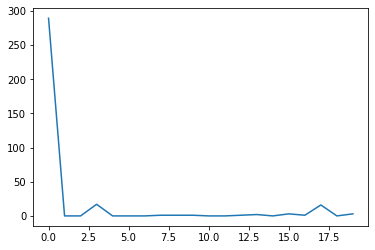

In [11]:
print(count1)
plt.plot(count1)
plt.show()

[0.8344, 0.9408, 0.9464, 0.9392, 0.9416, 0.9404, 0.9372, 0.9364, 0.9428, 0.9468, 0.9424, 0.9396, 0.9416, 0.9428, 0.9432, 0.9432, 0.9412, 0.9416, 0.9308, 0.9396]


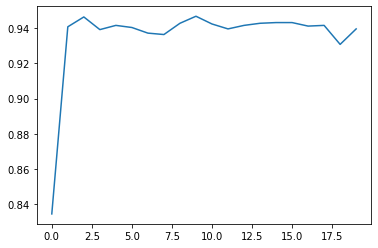

In [12]:
print(Correct_Acc1)
plt.plot(Correct_Acc1)
plt.show()